In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
import kagglehub

# Download Dataset for Lyft

In [17]:
# Download dataset
path = kagglehub.dataset_download("ravi72munde/uber-lyft-cab-prices")
print("Downloading weather and ride datasets...")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\O_s\.cache\kagglehub\datasets\ravi72munde\uber-lyft-cab-prices\versions\4


# Import Data

In [18]:
# Load data
df_rides = pd.read_csv(f'{path}/cab_rides.csv')
df_weather = pd.read_csv(f'{path}/weather.csv')

# DATA PREPROCESSING

In [19]:
# Convert timestamps
df_rides['date_time'] = pd.to_datetime(df_rides['time_stamp']/1000, unit='s')
df_weather['date_time'] = pd.to_datetime(df_weather['time_stamp'], unit='s')

# Merge on location, date, and hour
df_rides['loc_date_hr'] = df_rides['source'] + " - " + df_rides['date_time'].dt.date.astype(str) + " - " + df_rides['date_time'].dt.hour.astype(str)
df_weather['loc_date_hr'] = df_weather['location'] + " - " + df_weather['date_time'].dt.date.astype(str) + " - " + df_weather['date_time'].dt.hour.astype(str)
merged_df = pd.merge(df_rides, df_weather, on='loc_date_hr', suffixes=('', '_w'))
merged_df.dropna(inplace=True)

In [20]:
# Create hour and time category
merged_df['hour'] = merged_df['date_time'].dt.hour.astype(int)
def categorize_time(hour):
    if 6 <= hour <= 11:
        return 'Morning'
    elif 12 <= hour <= 17:
        return 'Afternoon'
    elif 18 <= hour <= 22:
        return 'Night'
    else:
        return 'Late Night'
merged_df['day_time'] = merged_df['hour'].apply(categorize_time)

# Drop unneeded columns
drop_cols = ['id', 'product_id', 'time_stamp', 'location', 'date_time', 'loc_date_hr', 'hour', 'time_stamp_w', 'date_time_w']
merged_df.drop(columns=drop_cols, inplace=True)

In [21]:
# Split Lyft and Uber
df_lyft = merged_df[merged_df['cab_type'] == 'Lyft'].copy()
df_uber = merged_df[merged_df['cab_type'] == 'Uber'].copy()

In [22]:
# Define features and targets
X_lyft = df_lyft.drop('price', axis=1)
y_lyft = df_lyft['price']
X_uber = df_uber.drop('price', axis=1)
y_uber = df_uber['price']

# Train-test split
X_train_lyft, X_test_lyft, y_train_lyft, y_test_lyft = train_test_split(X_lyft, y_lyft, test_size=0.2, random_state=42)
X_train_uber, X_test_uber, y_train_uber, y_test_uber = train_test_split(X_uber, y_uber, test_size=0.2, random_state=42)


In [31]:
# Preprocessing pipeline
str_attributes = ["cab_type", "name", "day_time"]
num_attributes = ["distance", "temp", "clouds", "pressure", "rain", "humidity", "wind", "surge_multiplier"]

pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attributes),
    ("cat", OneHotEncoder(handle_unknown="ignore"), str_attributes)
])

pipeline

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['distance', 'temp', 'clouds', 'pressure',
                                  'rain', 'humidity', 'wind',
                                  'surge_multiplier']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['cab_type', 'name', 'day_time'])])

In [32]:
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, dataset_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2 = r2_score(y_test, y_test_pred)

    # Cross-validated RMSE using a fresh pipeline
    model_for_cv = make_pipeline(pipeline, model.steps[-1][1])
    cv_rmse = -cross_val_score(model_for_cv, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5).mean()

    print(f"{model_name} - {dataset_name} - Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}, CV RMSE: {cv_rmse:.3f}, R²: {r2:.3f}")
    return rmse_train, rmse_test, cv_rmse, r2

# Models
models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Ridge Regression': Ridge(alpha=1.0),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results_lyft = {}
for name, reg in models.items():
    pipe = make_pipeline(pipeline, reg)
    print(f"--- {name} on Lyft ---")
    results_lyft[name] = evaluate_model(name, pipe, X_train_lyft, y_train_lyft, X_test_lyft, y_test_lyft, "Lyft")

--- Gradient Boosting on Lyft ---
Gradient Boosting - Lyft - Train RMSE: 1.550, Test RMSE: 1.558, CV RMSE: 1.562, R²: 0.975
--- K-Nearest Neighbors on Lyft ---
K-Nearest Neighbors - Lyft - Train RMSE: 1.683, Test RMSE: 2.119, CV RMSE: 2.196, R²: 0.955
--- Random Forest on Lyft ---
Random Forest - Lyft - Train RMSE: 1.414, Test RMSE: 1.524, CV RMSE: 1.524, R²: 0.977
--- Ridge Regression on Lyft ---
Ridge Regression - Lyft - Train RMSE: 2.520, Test RMSE: 2.534, CV RMSE: 2.521, R²: 0.935
--- XGBoost on Lyft ---
XGBoost - Lyft - Train RMSE: 1.429, Test RMSE: 1.489, CV RMSE: 1.498, R²: 0.978


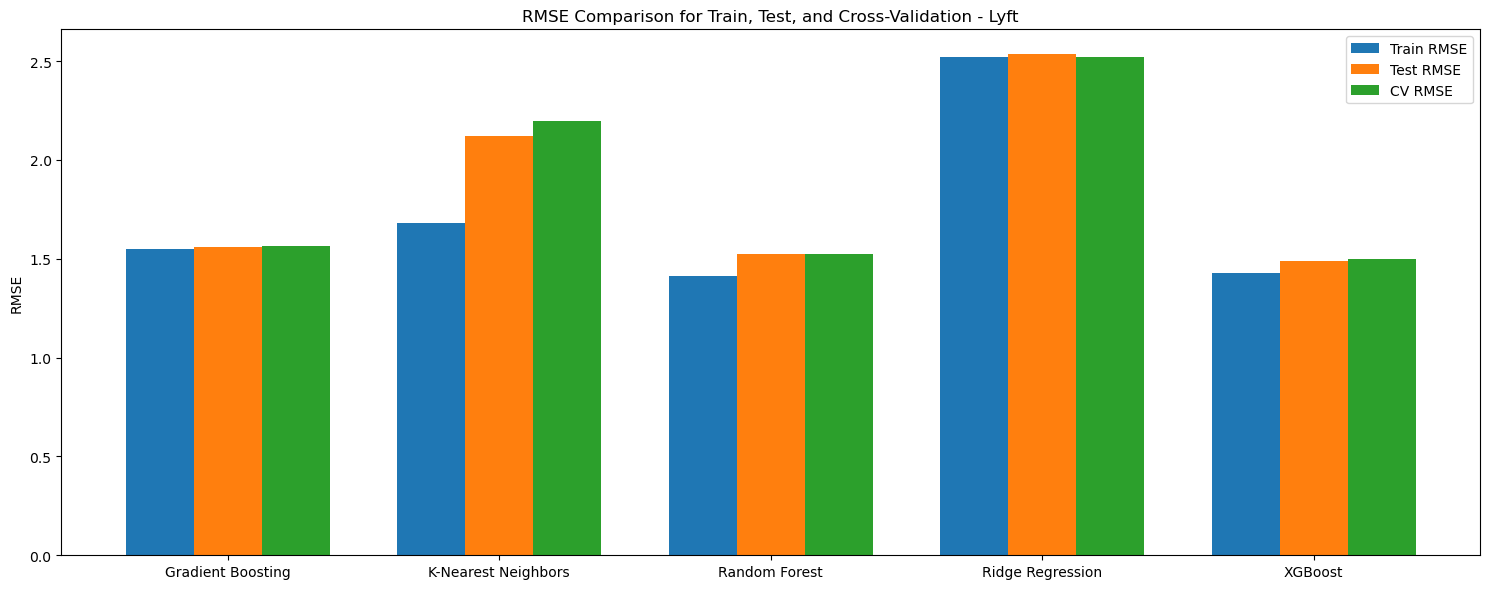

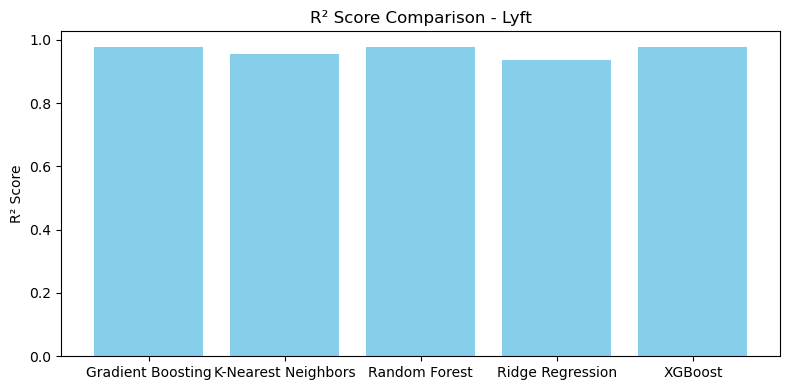

In [33]:
# Visualization
model_names = list(results_lyft.keys())
rmse_train_scores = [v[0] for v in results_lyft.values()]
rmse_test_scores = [v[1] for v in results_lyft.values()]
cv_rmse_scores = [v[2] for v in results_lyft.values()]
r2_scores = [v[3] for v in results_lyft.values()]

plt.figure(figsize=(15, 6))
bar_width = 0.25
x = np.arange(len(model_names))

plt.bar(x - bar_width, rmse_train_scores, width=bar_width, label='Train RMSE')
plt.bar(x, rmse_test_scores, width=bar_width, label='Test RMSE')
plt.bar(x + bar_width, cv_rmse_scores, width=bar_width, label='CV RMSE')

plt.xticks(x, model_names)
plt.ylabel("RMSE")
plt.title("RMSE Comparison for Train, Test, and Cross-Validation - Lyft")
plt.legend()
plt.tight_layout()
plt.show()

# Plot R² scores
plt.figure(figsize=(8, 4))
plt.bar(model_names, r2_scores, color='skyblue')
plt.ylabel("R² Score")
plt.title("R² Score Comparison - Lyft")
plt.tight_layout()
plt.show()


In [34]:
# Coefficients for models that support it
print("Model Coefficients (where applicable):")
for name, reg in models.items():
    if hasattr(reg, 'coef_') or hasattr(reg, 'feature_importances_'):
        pipe = make_pipeline(pipeline, reg)
        pipe.fit(X_train_lyft, y_train_lyft)

        # Get feature names
        ohe = pipe.named_steps['columntransformer'].named_transformers_['cat']
        encoded_cat_features = ohe.get_feature_names_out(str_attributes)
        all_features = np.concatenate([num_attributes, encoded_cat_features])

        # Extract coefficients or importances
        step_name = reg.__class__.__name__.lower().replace(" ", "_")
        if hasattr(pipe.named_steps[step_name], 'coef_'):
            coefs = pipe.named_steps[step_name].coef_
        elif hasattr(pipe.named_steps[step_name], 'feature_importances_'):
            coefs = pipe.named_steps[step_name].feature_importances_
        else:
            continue

        coef_df = pd.DataFrame({'Feature': all_features, 'Importance': coefs})
        coef_df_sorted = coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

        print(f"{name} Coefficients/Importances:")
        print(coef_df_sorted.to_string(index=False))


Model Coefficients (where applicable):
Gradient Boosting Coefficients/Importances:
            Feature   Importance
  name_Lux Black XL 4.568835e-01
           distance 1.484009e-01
     name_Lux Black 1.233756e-01
        name_Shared 1.102112e-01
   surge_multiplier 7.256060e-02
          name_Lyft 6.626198e-02
           name_Lux 2.201589e-02
       name_Lyft XL 2.330861e-04
               temp 1.732339e-05
               wind 1.284131e-05
           humidity 1.094898e-05
               rain 7.053249e-06
day_time_Late Night 5.658355e-06
           pressure 1.585636e-06
             clouds 1.006283e-06
 day_time_Afternoon 8.291110e-07
      cab_type_Lyft 0.000000e+00
   day_time_Morning 0.000000e+00
     day_time_Night 0.000000e+00
Random Forest Coefficients/Importances:
            Feature  Importance
  name_Lux Black XL    0.466657
           distance    0.160186
     name_Lux Black    0.157204
        name_Shared    0.085793
   surge_multiplier    0.069883
          name_Lyft    0.